## Mind Your Units In A Group-Randomized Experiment 

This is a bootstrap simulation that demonstrates the importance of accounting for the group structure as opposed to ignoring it in a group-randomized trials when performing causal inference. It is based on the ["Mind Your Units"](https://www.unofficialgoogledatascience.com/2016/08/mind-your-units.html) article published by Google. 

The simulation shows how ignoring the group structure leads to increasingly optimistic inferences, while accounting for the group structure leads to preserving the accurate coverage regardless of group size.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

plt.style.use('ggplot')

In [2]:
def getBootstrapSamples(data, ignoreGroupStruct, repeats = 2000, flatten = True):
    '''
    Function to get bootstrap samples by sampling with replacement from 'data'
    
    Args:
      data:                      Numeric array of data.
      ignoreGroupStruct:         Flag to indicate whether to ignore within-group dependence.
      repeats:                   Number of replicates.
      flatten:                   Flatten array.

    Returns:
      List of bootstrap samples
    '''
    
    containsNumpyArrays = np.sum([isinstance(el, np.ndarray) for el in data]) > 0
    
    # Create bootstrap samples.
    if ignoreGroupStruct:
        if containsNumpyArrays:
            data = np.concatenate(data)
        nGroups = len(data)
        samples = [np.random.choice(data, nGroups, replace=True) for i in range(repeats)]
    else:
        nGroups = len(data)
        sampleIndices = [np.random.choice(range(nGroups), nGroups, replace=True) for i in range(repeats)]
        samples = list(map(lambda arrIndices: [data[idx] for idx in arrIndices], sampleIndices))
        if flatten:
            samples = [np.concatenate(x) for x in samples]
        
    return samples

In [3]:
def computeBootstrapMeanCI(data, ignoreGroupStruct, repeats = 2000):
    '''
    Function to calculate confidence intervals for the mean via bootstrap.
    For bootstrap, we sample with replacement and each replicate is same size
    as original data; 95% CI obtained empirically by taking percentiles.
    
    Args:
      data:                      Numeric array of data.
      ignoreGroupStruct:         Flag to indicate whether to ignore within-group dependence.
      repeats:                   Number of bootstrap replicates.
    
    Returns:
      Mean and half-width of a 95% CI.
    '''
    # Get bootstrap samples.
    samples = getBootstrapSamples(data, ignoreGroupStruct, repeats)
    
    # Get sampling distribution and summarize empirically.
    means = [np.mean(arr) for arr in samples]
    mean = np.mean(means)
    halfWidth = (np.diff(np.quantile(means, (0.025, 0.975))) / 2)[0]
    
    return mean, halfWidth

In [4]:
# Inputs

numGroups = 50000  # Total number of groups for all simulations.
groupSd = 1  # This is the standard deviation for group level means.
withinGroupShrink = 0.25  # Shrinks standard dev. of w/in group observations.
lambdaVector = [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2]  # Poisson parameter for group size.
numReplicates = 2000  # Number of replicates for bootstrap.
numCoverageRepeats = 100  # Number of repeats for coverage calculation.
numCoverageCIRepeats = 10  # Number of repeats for coverage intervals calculation.

In [5]:
# Helper function to generate per-group observations.    
def SimulateGroupObservations(data):
    return np.random.normal(data[1], withinGroupShrink * groupSd, int(data[2]))

# Create a summary data frame to store results in.
summary = pd.DataFrame(columns=["Lambda", 
                                "% groups with more than one observation", 
                                "# observations", 
                                "CI half-width (ignore)", 
                                "CI half-width (account for)"])

# Generate the mean for each group and use this for all runs of simulation.
groupMeans = np.random.normal(0, groupSd, numGroups)

for param in lambdaVector:
    groupSizes = np.random.poisson(param, numGroups) + 1

    # Make data frame with group size & group mean for ease of computation.    
    groupDF = pd.DataFrame({
        "id": np.arange(1, numGroups + 1),
        "mean": groupMeans,
        "size": groupSizes
    })

    # Generate vector of per-group observations for all groups.
    obs = np.array([SimulateGroupObservations(x) for x in groupDF.values], dtype=object)

    # Compute CI pretending that each observation is independent.        
    ignoreCI = computeBootstrapMeanCI(obs, True, numReplicates)

    # Compute CI accounting for the group structure.
    includeCI = computeBootstrapMeanCI(obs, False, numReplicates)    

    # Formulate data frame to summarize results.
    row = [param, 
           str(round(np.sum(groupSizes > 1) / numGroups * 100, 2)) + "%", 
           np.sum(groupSizes), 
           ignoreCI[1], 
           includeCI[1]]
    summary.loc[len(summary)] = row
    
summary

,Lambda,% groups with more than one observation,# observations,CI half-width (ignore),CI half-width (account for)
0,0,0.0%,50000,0.008983,0.008874
1,0.2,18.31%,60091,0.008172,0.009410
2,0.4,33.14%,70107,0.007769,0.009943
3,0.6,45.18%,80094,0.007098,0.009401
4,0.8,55.14%,89873,0.006571,0.009754
5,1,63.26%,100152,0.006312,0.009918
6,1.2,69.92%,110106,0.006100,0.009833


In [6]:
# Create a summary data frame to store results in.
coverageSummary = pd.DataFrame(columns=["Lambda", "Sim Type", "Coverage"])

# True value of the estimand
estimand = 0

# Generate the mean for each group and use this for all runs of simulation.
groupMeans = np.random.normal(0, groupSd, numGroups)

for param in lambdaVector:
    groupSizes = np.random.poisson(param, numGroups) + 1

    # Make data frame with group size & group mean for ease of computation.    
    groupDF = pd.DataFrame({
        "id": np.arange(1, numGroups + 1),
        "mean": groupMeans,
        "size": groupSizes
    })

    for i in range(numCoverageCIRepeats):

        # Case for ignoring the group structure
        ignoreCov = 0
        includeCov = 0
        for j in range(numCoverageRepeats):

            # Generate vector of per-group observations for all groups.
            obs = np.array([SimulateGroupObservations(x) for x in groupDF.values], dtype=object)

            # Compute CI pretending that each observation is independent.        
            ignoreM, ignoreCI = computeBootstrapMeanCI(obs, True, numReplicates)

            # Count if the true value of the estimand lies in the interval.
            if estimand >= ignoreM - ignoreCI and estimand <= ignoreM + ignoreCI:
                ignoreCov += 1

            # Compute CI accounting for the group structure.
            includeM, includeCI = computeBootstrapMeanCI(obs, False, numReplicates)

            # Count if the true value of the estimand lies in the interval.
            if estimand >= includeM - includeCI and estimand <= includeM + includeCI:
                includeCov += 1

        # Add the calculated coverage for the "ignore" case to the summary data frame.
        row = [param, 
               "Ignore group",
               ignoreCov / numCoverageRepeats]
        coverageSummary.loc[len(coverageSummary)] = row            

        # Add the calculated coverage for the "include" case to the summary data frame.
        row = [param, 
               "Account for group",
               includeCov / numCoverageRepeats]
        coverageSummary.loc[len(coverageSummary)] = row

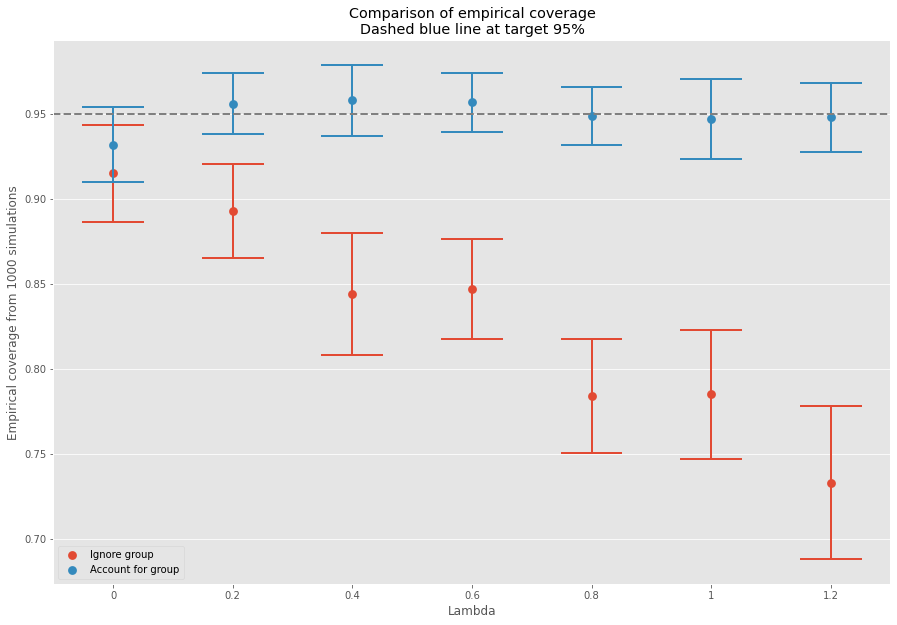

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.pointplot(x="Lambda", y="Coverage", hue="Sim Type", data=coverageSummary, ci="sd", errwidth=2, capsize=0.5, join=False)
ax.axhline(0.95, ls='--', lw=2, color='gray')
ax.set_title("Comparison of empirical coverage\nDashed blue line at target 95%")
ax.set_ylabel("Empirical coverage from 1000 simulations")
plt.legend(loc='lower left');